Comparing clustering-classification, classification and all features with each other

# Imports

In [1]:
#Omid55
import requests
import pandas as pd
import pickle as pk
import csv
import time
import numpy as np
import random
from collections import defaultdict
import seaborn as sns
import matplotlib.pylab as plt
from scipy.sparse import csr_matrix
import networkx as nx
import glob
import networkx
import scipy
import classification_pipeline as pi
% matplotlib inline

# Useful Classes and Functions

In [2]:
def is_she_has_similar_history_in_stats_and_training(sid):
    # if there is at least 50% of training in the stats, we consider her as good
    r = len(list(set(summoners_training[sid].champions.keys()) - set(summoners_stats[sid].champions.keys()))) / float(len(summoners_training[sid].champions.keys()))
    return r < 0.5

In [3]:
"""Brief and useful info Match class"""
class Match:
    def __init__(self):
        self.summonerIds_championIds_isWinner_tier = []
        self.matchCreation = 0
        self.matchDuration = 0
        self.matchId = 0
        self.matchMode = ""
        self.matchType = ""
        
    def __init__(self, match):
        self.summonerIds_championIds_isWinner_tier = get_summonerIds_championIds_isWinner_tier(match)
        self.matchCreation = match['matchCreation']
        self.matchDuration = match['matchDuration']
        self.matchId = match['matchId']
        self.matchMode = match['matchMode']
        self.matchType = match['matchType']
        
    def __str__(self):
        return 'id:' + str(self.matchId) + ', mode:' + str(self.matchMode) + ', type:' + str(self.matchType) + ', creation:' + str(self.matchCreation) + ', duration:' + str(self.matchDuration) + ', my stats:' + str(self.summonerIds_championIds_isWinner_tier)
    

In [4]:
"""ChampionResult is a simple class with number of
    wins and loses as integer value"""
class ChampionResult:
    def __init__(self):
        self.wins = 0
        self.loses = 0
    
    def get_win_ratio(self):
        #assert self.wins + self.loses != 0, 'There is no matches available...'
        if not self.wins + self.loses:
            return 0
        return self.wins / float(self.wins + self.loses)
    
    def get_game_count(self):
        return self.wins + self.loses
        
        
"""SummonerChampionStats has a hashtable of champions which
    describes how many time summoner won or lost with that
    (GameResult as each item)"""
class SummonerChampionStats:
    def __init__(self):
        self.champions = defaultdict(lambda: ChampionResult())
    
    def get_game_count(self):
        return sum([c.get_game_count() for c in self.champions.values()])
    
    def get_win_ratio(self):
        w = sum([c.wins for c in self.champions.values()])
        l = sum([c.loses for c in self.champions.values()])
        #assert w + l != 0, 'There is no matches available...'
        if not w + l:
            return 0
        return w / float(w+l)
        
    def get_same_champion_game_count(self, champId):
        return self.champions[champId].get_game_count()
        
    def get_same_champion_win_ratio(self, champId):
        return self.champions[champId].get_win_ratio()
        

In [5]:
# preprocessing summoners from matches in order to have a dictionary of summoners with
#    a dictionary of their previous selected champions and GameResult for
#       for each selected champion (wins and loses)
def preprocess_given_matches(previous_matchIds_for_stats):
    summoners_stats = defaultdict(lambda: SummonerChampionStats())
    for mid in previous_matchIds_for_stats:
        summoner_champ_winner = matches[mid].summonerIds_championIds_isWinner_tier
        for s in summoner_champ_winner:
            if s[2]:
                summoners_stats[s[0]].champions[s[1]].wins += 1
            else:
                summoners_stats[s[0]].champions[s[1]].loses += 1
    return summoners_stats

Get the index for a sid in the network, it adds a new node if sid does not exist

In [6]:
def get_the_index_for_sid(sid):
    if sid not in sid_map:
        sid_map[sid] = len(sid_map)
    return sid_map[sid]

# in general format
def get_index_for(dictionary, val):
    if val not in dictionary:
        dictionary[val] = len(dictionary)
    return dictionary[val]

Get a list of network features for a given adjacency matrix

In [7]:
net_metric_names = ['AC', 'clustering', 'shortest_path_length', 'diameter', 'spectrum_v1', 'spectrum_v2', 'spectrum_v3', 'spectrum_v4', 'spectrum_v5']

def get_network_metrics(A):
    #nx.draw(A)
    return [nx.algebraic_connectivity(A), nx.average_clustering(A),
        nx.average_shortest_path_length(A) if nx.is_connected(A) else -1, 
            nx.diameter(A) if nx.is_connected(A) else -1] + list(nx.laplacian_spectrum(A))

Compute the weight between two nodes in the entire giant network 

In [8]:
def compute_weight_between_two_nodes_in_large_network(weighted_network, weighted_network_graph, n1, n2):
    assert type(weighted_network) == scipy.sparse.csr.csr_matrix, 'weighted_network is not a sparse matrix ...'
    assert type(weighted_network_graph) == networkx.classes.graph.Graph, 'weighted_network_graph is not a networkx graph ...'
    try:
        path = nx.shortest_path(weighted_network_graph, n1, n2)
    except:
        return 1000   # if there is not path and it has been raised nx.NetworkXNoPath then there is a large distance
    distance = 0
    for i in range(len(path)-1):
        distance += 1.0 / weighted_network[path[i], path[i+1]]
    return distance

In [9]:
def my_maximum (A, B):
    BisBigger = A-B
    BisBigger.data = np.where(BisBigger.data < 0, 1, 0)
    return A - A.multiply(BisBigger) + B.multiply(BisBigger)

In [10]:
def plot_win_loses_distribution(data_type, summoners, sid):
    dd = []
    for k, v in summoners_stats[sid].champions.items():
        dd.append([k, v.wins, 'Wins'])
        dd.append([k, v.loses, 'Loses'])
    dtt = pd.DataFrame(dd, columns=['Champion ID', 'Count', 'Result'])
    fig = sns.barplot(x="Champion ID", y="Count", hue="Result", data=dtt)
    fig.set_title('Win/Lose distribution for each champion in the ' + data_type + ' data');
    plt.ylabel('Distribution', fontsize=16)
    fig.savefig(str(sid)+'.png')
    

# Loading the whole data

In [11]:
# # loading all saved matches
# matches = {}
# for fname in glob.glob("MATCHES_till_sid*.pkl"):
#     print(fname)
#     with open(fname, 'rb') as f:
#         matches_chunk = pk.load(f)    
#         matches = dict(matches.items()+matches_chunk.items())   # adding all matches together

with open('TOTLA_MATCHES.pkl', 'rb') as f:
    matches = pk.load(f)

In [12]:
print 'Length of all matches is', len(matches)

Length of all matches is 208711


# Separating the data to 3 parts: Stats, Training and Test Dataset

In [13]:
# selecting a sample of matches
SAMPLE_IT = False
if SAMPLE_IT:
    SAMPLE_SIZE = 10000
    sampled_matches_ids = [matches.keys()[s] for s in sorted(random.sample(range(len(matches)), SAMPLE_SIZE))]
else:  # all the data
    sampled_matches_ids = matches.keys()

# sorting matches with respect to their match creation date
dates = np.zeros(len(sampled_matches_ids))
for i, mid in enumerate(sampled_matches_ids):
    dates[i] = matches[mid].matchCreation
sampled_matches_ids_sorted = [x for (y,x) in sorted(zip(dates, sampled_matches_ids))]
#all(dates[i]<=dates[i+1] for i in range(len(dates)-1))  # for checking if this is sorted or no

# spliting the data to 70% for stats and 20% for training and 10% for testing 
stats_len = int(0.6*len(sampled_matches_ids_sorted))
training_len = int(0.2*len(sampled_matches_ids_sorted))
matchIds_for_stats = sampled_matches_ids_sorted[:stats_len]
matchIds_for_training_dataset = sampled_matches_ids_sorted[stats_len:stats_len+training_len]
matchIds_for_test_dataset = sampled_matches_ids_sorted[stats_len+training_len:]
print 'Length of matchIds_for_stats is\t\t\t', len(matchIds_for_stats), \
    '\nLength of matchIds_for_training_dataset is\t', len(matchIds_for_training_dataset), \
    '\nLength of matchIds_for_test_dataset is\t\t', len(matchIds_for_test_dataset)

Length of matchIds_for_stats is			125226 
Length of matchIds_for_training_dataset is	41742 
Length of matchIds_for_test_dataset is		41743


# Building the network of games from stats data

In [14]:
# finding the number of unique summoners
all_sids_in_stats = []
for mid in matchIds_for_stats:
    sc = matches[mid].summonerIds_championIds_isWinner_tier
    all_sids_in_stats+=[s[0] for s in sc]
N = len(set(all_sids_in_stats))
del all_sids_in_stats
print('There are', N, 'unique summoners in the stats data.')

('There are', 573069, 'unique summoners in the stats data.')


In [15]:
sid_map = {}
edges = defaultdict(lambda: 0)
for mid in matchIds_for_stats:
    sc = matches[mid].summonerIds_championIds_isWinner_tier
    for i in range(len(sc)):
        for j in range(i+1, len(sc)):
            if sc[i][2] == sc[j][2]:   # if they were in the same team
                key = str(get_the_index_for_sid(sc[i][0])) + ',' + str(get_the_index_for_sid(sc[j][0]))
                edges[key] += 1
row, col, val = [], [], []
for k, v in edges.items():
    coordination = k.split(',')
    row.append(int(coordination[0]))
    col.append(int(coordination[1]))
    val.append(v)
# since N is so large, we build a sparse matrix to save the entire network in it
W = csr_matrix((val, (row, col)), shape=(N,N), dtype=np.int8)
del edges, row, col, val

/cs/student/omid55/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2645: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [16]:
W = my_maximum(W, np.transpose(W))
WG = nx.Graph(W)

Preprocessing the summoners in the stats data

In [17]:
summoners_stats = preprocess_given_matches(matchIds_for_stats)
summoners_training = preprocess_given_matches(matchIds_for_training_dataset)

See if people in training dataset and stats have similar champion choices (distribution)

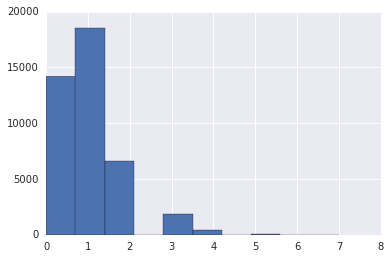

In [18]:
good_sids = []
for sid in summoners_training.keys():
    if is_she_has_similar_history_in_stats_and_training(sid):
        good_sids.append(sid)
        
# Now we only consider those in the test set which are consisted of only good sids in their teams
cs = []
for mid in matchIds_for_test_dataset:
    sids = [m[0] for m in matches[mid].summonerIds_championIds_isWinner_tier]
    c = len(np.where(np.array([s in good_sids for s in sids]) == True)[0])
    cs.append(c)
plt.hist(cs);

# RUN FROM HERE

In [19]:
def make_the_dataset(dataset_fname, experience_features = True, network_features = True):
    THRESHOLD = 4
    selected_indices = np.where(np.array(cs)>=THRESHOLD)[0]
    matchIds_for_test_dataset_selected = [matchIds_for_test_dataset[i] for i in selected_indices]

    # building the dataset now:::
    # for each match in the dataset
    winner_edge_count = []
    loser_edge_count = []
    winner_weights = []
    loser_weights = []
    data = []
    for mid in matchIds_for_test_dataset_selected:
        summoners_not_found_winner = 0
        summoners_not_found_loser = 0
        winners = []
        losers = []

        sc = matches[mid].summonerIds_championIds_isWinner_tier
        # for team network 
        w_dict = {}
        l_dict = {}
        W_winner_team = np.zeros((5,5))
        W_loser_team = np.zeros((5,5))
        for i in range(len(sc)):
            for j in range(i+1, len(sc)):
                if sc[i][2] == sc[j][2]:
                    if sc[i][0] in sid_map and sc[j][0] in sid_map:
                        if sc[i][2]:
                            ii = get_index_for(w_dict,i)
                            jj = get_index_for(w_dict,j)
                            W_winner_team[ii,jj] = compute_weight_between_two_nodes_in_large_network\
                                (W, WG, get_the_index_for_sid(sc[i][0]), get_the_index_for_sid(sc[j][0]))
                            W_winner_team[jj,ii] = W_winner_team[ii,jj]
                        else:
                            ii = get_index_for(l_dict,i)
                            jj = get_index_for(l_dict,j)
                            W_loser_team[ii,jj] = compute_weight_between_two_nodes_in_large_network\
                                (W, WG, get_the_index_for_sid(sc[i][0]), get_the_index_for_sid(sc[j][0]))
                            W_loser_team[jj,ii] = W_loser_team[ii,jj]
        # thus we have winner weights, loser weights
        #   and their adjacency matrix as W_winner_team, W_loser_team
        wg = nx.Graph(W_winner_team)
        lg = nx.Graph(W_loser_team)
        winner_edge_count.append(np.count_nonzero(W_winner_team)/2)
        loser_edge_count.append(np.count_nonzero(W_loser_team)/2)
        winner_weights.append(sum(sum(W_winner_team)))
        loser_weights.append(sum(sum(W_loser_team)))
        
        # for each member in each team
        for s in sc:
            stat = summoners_stats[s[0]]
            tmp = [
                stat.get_game_count(),
                stat.get_win_ratio(),
                stat.get_same_champion_game_count(s[1]),
                stat.get_same_champion_win_ratio(s[1])
            ]
            if s[2]:
                winners.append(tmp)
            else:
                losers.append(tmp)

        sample = []
        if experience_features:
            if not winners:
                sample += [0, 0]
            else:
                sample += list(np.average(winners, axis=0)) + \
                    list(np.std(winners, axis=0))

        if network_features:
            sample += [np.average(sum(W_winner_team)),
                np.std(sum(W_winner_team))] + \
                get_network_metrics(wg)
        if experience_features:        
            if not losers:
                sample += [0, 0]
            else:
                sample += list(np.average(losers, axis=0)) + \
                list(np.std(losers, axis=0))
        if network_features:
            sample += [np.average(sum(W_loser_team)),
                    np.std(sum(W_loser_team))] + \
                    get_network_metrics(lg)
        data.append(sample)

    print('Data length is', len(data))

    # names for the features in the dataset
    names = ['avg_game_count', 'std_game_count', 'avg_win_ratio', 'std_win_ratio', 'avg_same_champion_game_count', 
                 'std_same_champion_game_count', 'avg_same_champion_win_ratio', 'std_same_champion_win_ratio', 
                             'average_weight', 'std_weight'] + net_metric_names
    feature_names = ['winner_' + na for na in names] + ['loser_' + na for na in names]
    
    dataset = pd.DataFrame(data=data)
    #dataset = pd.DataFrame(data=data, columns= feature_names)

    dataset.to_csv(dataset_fname)
    return winner_edge_count, loser_edge_count, winner_weights, loser_weights

# Building 3 different datasets

In [20]:
file_names = ['DATA_2016_Nodes.csv', 'DATA_2016_Networks.csv', 'DATA_2016_Nodes+Networks.csv']

make_the_dataset(file_names[0], experience_features=True, network_features=False);
make_the_dataset(file_names[1], experience_features=False, network_features=True);
make_the_dataset(file_names[2], experience_features=True, network_features=True);

('Data length is', 577)
('Data length is', 577)
('Data length is', 577)


# Comparing all models together

In [100]:
def compare_multiple_models(runs=30, number_of_clusters=4, linkage='complete', distance='cosine', verbose=False):
    # computing all svms
    res = []
    res_train = []
    for fn in file_names:
        r = pi.run_multiple_times_svm_with_tunning(fn, 
                                               runs=runs, 
                                               number_of_clusters=number_of_clusters, linkage=linkage, distance=distance, 
                                               verbose=verbose)
        res += [r[0]]
        res_train += [r[1]]
    #plot_bars(res, 'Test Accuracy')
    #plt.figure()
    #plot_bars(res_train, 'Train Accuracy')
    return res, res_train
        
def plot_bars(res, title_str, apply_ylimit=False):
    # building the result dataframe
    dt = []
    feature_set_names = ['node', 'network', 'node + network']
    for j in range(len(res)):
        for i in range(len(res[j].classification_accuracies)):
            dt.append([res[j].classification_accuracies[i], 'Classification', feature_set_names[j]])
            dt.append([res[j].clustering_classification_accuracies[i], 'Clustering then Classification', feature_set_names[j]])
    RS = pd.DataFrame(data=dt, columns=['Accuracy', 'Method', 'Feature Set'])

    # plotting the barplot
    sns.set(rc={"figure.figsize": (12, 12)})
    ax = sns.barplot(x="Feature Set", y="Accuracy", hue="Method", data=RS)
    if apply_ylimit:
        plt.ylim(50, 60);
    plt.title(title_str)
    return plt

# Run for different clustering and classification models

In [101]:
pi = reload(pi)
res4, res_train4 = compare_multiple_models(runs=30, number_of_clusters=4, linkage='complete', distance='cosine', verbose=False)

Starting ...
Loaded data size:  (577, 17)
Swapping  8.0 : 16.0  with 0 : 8.0  ...
Dataset size:  (577, 17)
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * Starting ...
Loaded data size:  (577, 23)
Swapping  11.0 : 22.0  with 0 : 11.0  ...
Dataset size:  (577, 23)
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * Starting ...
Loaded data size:  (577, 39)
Swapping  19.0 : 38.0  with 0 : 19.0  ...
Dataset size:  (577, 39)
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

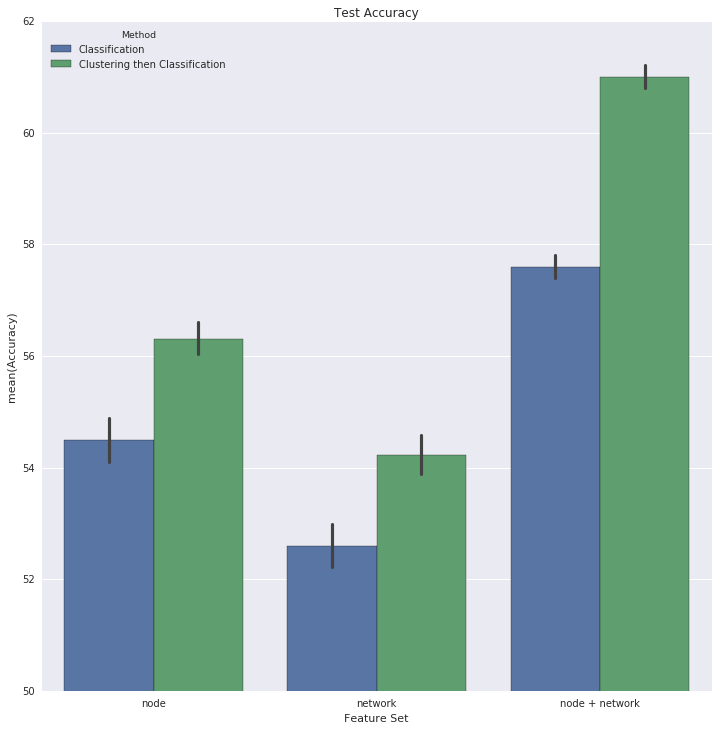

In [105]:
plot_bars(res4, 'Test Accuracy', apply_ylimit=False)
plt.ylim(50, 62);

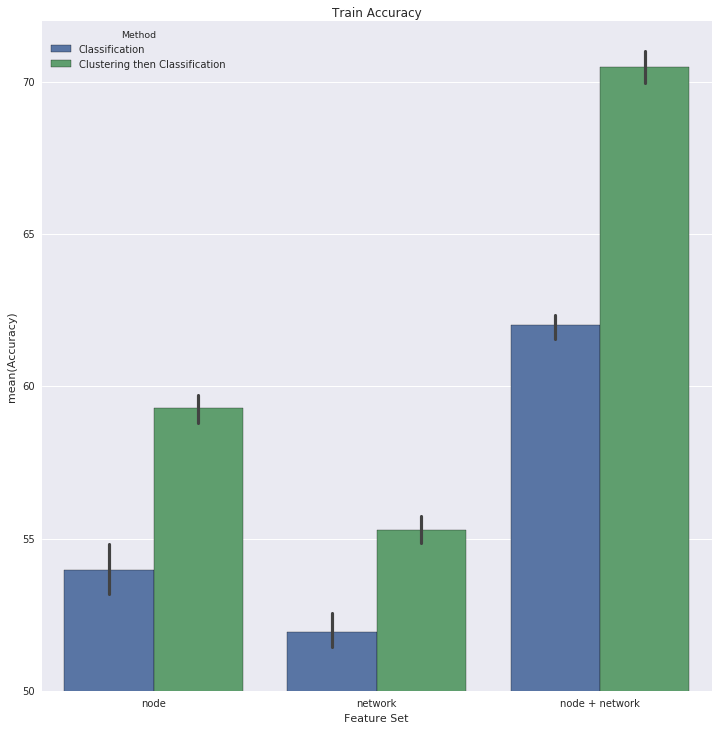

In [108]:
plot_bars(res_train4, 'Train Accuracy', apply_ylimit=False)
plt.ylim(50, 72);